In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from bicycle.lightning_model import BICYCLE
import torch
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from bicycle.dictlogger import DictLogger
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
import seaborn as sns

In [3]:
SEED = 3141
pl.seed_everything(SEED)

torch.set_float32_matmul_precision("medium")

Global seed set to 3141


In [4]:
batch_size = 512
N_SAMPLES = 0.5
HARD_THRESHOLD = True
num_downstream_genes = 5
num_perturbation_genes = 10

In [5]:
CUDA = torch.cuda.is_available()
device = torch.device("cpu")
if CUDA:
    GPU_DEVICE = 0
    torch.cuda.set_device(GPU_DEVICE)
    device = torch.device("cuda")

DATA_PATH = Path("/data/m015k/data/bicycle")

In [6]:
adata = sc.read_h5ad(DATA_PATH / "NormanWeissman2019_filtered.h5ad")

# Remove all genes with 0 variance
adata = adata[:, adata.X.todense().var(axis=0) > 0]

def cdf(x):
    # Calculate and plot cumulative distribution function from 1D-samples
    x, y = sorted(x), np.arange(len(x)) / len(x)
    return (x, y)

gene_set = adata.obs.perturbation.unique()[:10]

var_names = adata.var_names.to_list()

for gene in gene_set:
    if gene in var_names:
        plt.figure()
        plt.title(gene)
        x_obs, y_obs = cdf(
            np.asarray(
                adata[adata.obs["perturbation"] == "control", gene].X.todense()
            ).squeeze()
        )
        plt.plot(x_obs, y_obs, label="unperturbed: %d cells" % len(x_obs))

        x_obs, y_obs = cdf(
            np.asarray(
                adata[adata.obs["perturbation"] == gene, gene].X.todense()
            ).squeeze()
        )
        plt.plot(x_obs, y_obs, label="perturbed: %d cells" % len(x_obs))

        plt.legend()

        plt.show()

In [7]:
adata.obs.head()

,guide_id,read_count,UMI_count,coverage,gemgroup,good_coverage,number_of_cells,tissue_type,cell_line,cancer,disease,perturbation_type,celltype,organism,perturbation,nperts,ngenes,ncounts,percent_mito,percent_ribo
TTGAACGAGACTCGGA,ARID1A_NegCtrl0;ARID1A_NegCtrl0,28684,1809,15.856274,2,True,1,cell_line,K562,True,chronic myelogenous leukemia,CRISPR,lymphoblasts,human,ARID1A,1,3079,15097.0,5.815725,33.569583
CGTTGGGGTGTTTGTG,BCORL1_NegCtrl0;BCORL1_NegCtrl0,18367,896,20.498884,7,True,1,cell_line,K562,True,chronic myelogenous leukemia,CRISPR,lymphoblasts,human,BCORL1,1,2100,8551.0,4.104783,45.842592
GAACCTAAGTGTTAGA,FOSB_NegCtrl0;FOSB_NegCtrl0,16296,664,24.542169,6,True,1,cell_line,K562,True,chronic myelogenous leukemia,CRISPR,lymphoblasts,human,FOSB,1,2772,10999.0,5.655060,17.801618
CCTTCCCTCCGTCATC,SET_KLF1;SET_KLF1,16262,850,19.131765,4,True,1,cell_line,K562,True,chronic myelogenous leukemia,CRISPR,lymphoblasts,human,SET_KLF1,2,5385,38454.0,4.335050,38.165080
TCAATCTGTCTTTCAT,OSR2_NegCtrl0;OSR2_NegCtrl0,16057,1067,15.048735,2,True,2,cell_line,K562,True,chronic myelogenous leukemia,CRISPR,lymphoblasts,human,OSR2,1,4869,27926.0,5.084867,32.317554


In [8]:
# Subsample rows randomly
if N_SAMPLES:
    if N_SAMPLES < 1:
        # Subsample adata to N per cent of samples
        adata = adata[
            np.random.choice(
                adata.shape[0], int(N_SAMPLES * adata.shape[0]), replace=False
            ),
            :,
        ]
    else:
        # Subsample adata to N samples
        adata = adata[np.random.choice(adata.shape[0], N_SAMPLES, replace=False), :]

In [9]:
# Genes that must be included
prio_downstream_genes = ["MMP13"]
prio_perturbation_genes = ["TGFBR2"]

# Print if genes are found or not in data
for gene in prio_downstream_genes:
    if gene in adata.var.index:
        print(f"✓ Gene {gene} found in data")
    else:
        print(f"✗ Gene {gene} not found in data")
        prio_downstream_genes.remove(gene)

for gene in prio_perturbation_genes:
    if gene in adata.obs.perturbation.unique():
        print(f"✓ Gene {gene} found in data")
    else:
        print(f"✗ Gene {gene} not found in data")
        # Remove gene from prio_perturbation_genes
        prio_perturbation_genes.remove(gene)

✗ Gene MMP13 not found in data
✓ Gene TGFBR2 found in data


results = prepare_dataset(
    adata,
    p_val=0.2,
    p_test=0.2,
    min_perturbed_cells=0,
    use_clusters_for_holdout=True,
    stratify_regimes=True,
)

In [10]:
# Find all genes that have been perturbed at least once
perturbed_genes = adata.obs.perturbation.unique()
perturbed_genes = [
    x for x in perturbed_genes if (not "_" in x) & (x in adata.var.index)
]
perturbation_genes = list(set(perturbed_genes))
print(f"Number of single perturbations: {len(perturbation_genes)}")
print(perturbation_genes)

Number of single perturbations: 102
['MAP2K6', 'CBL', 'FOXA3', 'AHR', 'CDKN1C', 'SGK1', 'MAP2K3', 'SAMD1', 'ATL1', 'PRTG', 'ZC3HAV1', 'CITED1', 'ZNF318', 'CLDN6', 'COL1A1', 'NIT1', 'GLB1L2', 'CELF2', 'MEIS1', 'IRF1', 'STIL', 'SLC38A2', 'PTPN12', 'UBASH3A', 'ARRDC3', 'HES7', 'LHX1', 'HK2', 'TSC22D1', 'RREB1', 'BPGM', 'BCL2L11', 'ZBTB25', 'RHOXF2', 'MAPK1', 'CKS1B', 'TP73', 'TMSB4X', 'HOXC13', 'KIF2C', 'HOXB9', 'OSR2', 'DUSP9', 'PTPN1', 'JUN', 'FOXO4', 'POU3F2', 'UBASH3B', 'PLK4', 'CDKN1A', 'ARID1A', 'ELMSAN1', 'SLC4A1', 'CEBPA', 'ZBTB10', 'MAP4K3', 'LYL1', 'ETS2', 'CDKN1B', 'IKZF3', 'FEV', 'MIDN', 'SLC6A9', 'BCORL1', 'TGFBR2', 'SNAI1', 'CNN1', 'MAP7D1', 'KIF18B', 'FOXA1', 'CBFA2T3', 'DLX2', 'KMT2A', 'MAP4K5', 'CEBPE', 'TBX3', 'FOXL2', 'KLF1', 'COL2A1', 'SPI1', 'MAML2', 'TBX2', 'CNNM4', 'S1PR2', 'FOXF1', 'FOSB', 'EGR1', 'PTPN13', 'PTPN9', 'ISL2', 'BAK1', 'CSRNP1', 'ZBTB1', 'RUNX1T1', 'CEBPB', 'IGDCC3', 'HOXA13', 'NCL', 'PRDM1', 'SET', 'IER5L', 'HNF4A']


In [11]:
# CLUSTER perturbations
import math

pert_name = "perturbation"
intervened_variables = perturbation_genes

adata_perturbed = adata[adata.obs[pert_name].isin(intervened_variables)]
sc.tl.dendrogram(adata_perturbed, groupby=pert_name)
clusters = list()

# Individual leave colors
dp = "dendrogram_" + pert_name
di = "dendrogram_info"
leave_colors = adata_perturbed.uns[dp][di]["leaves_color_list"]
names = adata_perturbed.uns[dp][di]["ivl"]

for leave_color in set(leave_colors):
    cluster = [names[i] for i, lc in enumerate(leave_colors) if lc == leave_color]
    clusters.append(cluster)

for c in clusters:
    print(f"Lenght of cluster: {len(c)}")

         Falling back to preprocessing with `sc.pp.pca` and default params.
Lenght of cluster: 2
Lenght of cluster: 24
Lenght of cluster: 40
Lenght of cluster: 22
Lenght of cluster: 14


In [12]:
# Find cluster of prio_perturbation_genes
perturbation_cluster = []
for idx, c in enumerate(clusters):
    if any([x in c for x in prio_perturbation_genes]):
        perturbation_cluster.extend(c)

In [13]:
# Select a subset of genes, but only those that are in the data
selected_perturbed_genes = perturbation_cluster
all_perturbation_wo_pairs = [
    x
    for x in adata.obs.perturbation.to_list()
    if (not "_" in x) & (x in adata.var.index)
]
if len(selected_perturbed_genes) > num_perturbation_genes:
    print("Warning: selected more genes than initially planned")
    if HARD_THRESHOLD:
        print("- Using hard threshold")
        selected_perturbed_genes = selected_perturbed_genes[:num_perturbation_genes]
else:
    not_included_genes = list(
        set(all_perturbation_wo_pairs) - set(selected_perturbed_genes)
    )
    selected_perturbed_genes = (
        selected_perturbed_genes
        + not_included_genes[: (num_perturbation_genes - len(selected_perturbed_genes))]
    )
selected_perturbed_genes = selected_perturbed_genes + ["control"]
print(selected_perturbed_genes)

- Using hard threshold
['CNN1', 'PTPN12', 'SET', 'CSRNP1', 'MAP2K3', 'MAP2K6', 'TGFBR2', 'ELMSAN1', 'BAK1', 'MAML2', 'control']


selected_perturbed_genes_wo_control = [
    x for x in selected_perturbed_genes if x != "control"
]
np.corrcoef(
    adata[:, selected_perturbed_genes_wo_control].X.todense(), rowvar=False
)[: len(selected_perturbed_genes_wo_control), -1].shape

In [14]:
selected_perturbed_genes_wo_control = [
    x for x in selected_perturbed_genes if x != "control"
]

# Find genes that are highly correlated with genes in selected_perturbed_genes
x1 = adata[:, selected_perturbed_genes_wo_control].X.todense()
names = [x for x in adata.var.index if x not in selected_perturbed_genes_wo_control]
x2 = adata[:, names].X.todense()

In [15]:
# Subsample both dfs
n_samples = 1000
idx = np.random.choice(x1.shape[0], 1000, replace=False)
x1 = x1[idx, :]
x2 = x2[idx, :]
# Compute column wise correlation between x1 and x2
corr = np.corrcoef(x1, x2, rowvar=False)

/data/m015k/miniconda3/envs/bi/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/m015k/miniconda3/envs/bi/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [16]:
c = np.abs(
    corr[
        len(selected_perturbed_genes_wo_control) :,
        : len(selected_perturbed_genes_wo_control),
    ]
)

import seaborn as sns
sns.heatmap(c, cmap="vlag", center=0)

In [17]:
def top_indices(matrix):
    flat_indices = np.argsort(matrix.ravel())[::-1]
    row_indices, _ = np.unravel_index(flat_indices, matrix.shape)
    return row_indices


top_row_indices = list(top_indices(c, num_downstream_genes))
# Selct first num_downstream_genes different genes
top_genes = []
for k in top_row_indices:
    if not names[k] in top_genes:
        top_genes.append(names[k])
    if len(top_genes) == num_downstream_genes:
        break
print("Top row indices:", top_genes)

prio_downstream_genes = list(set(prio_downstream_genes) | set(top_genes))

Top row indices: ['LL09NC01-139C3.1', 'FUT7', 'RP11-216L13.17', 'LCNL1', 'ENTPD2']


In [18]:
# All genes in study we care about
all_gene_in_graph = list(
    (set(selected_perturbed_genes) | set(prio_downstream_genes)) - set(["control"])
)
print(all_gene_in_graph)
assert any([x for x in selected_perturbed_genes if x not in all_gene_in_graph])

['MAP2K6', 'FUT7', 'BAK1', 'ELMSAN1', 'LL09NC01-139C3.1', 'CSRNP1', 'TGFBR2', 'LCNL1', 'MAP2K3', 'ENTPD2', 'PTPN12', 'CNN1', 'MAML2', 'RP11-216L13.17', 'SET']


In [19]:
samples = adata
print(samples.shape)

# Subset obs data to only include perturbation we want to use
samples = adata[adata.obs.perturbation.isin(selected_perturbed_genes), :]
print(samples.shape)

# Optional: subset genes
samples = samples[:, samples.var.index.isin(all_gene_in_graph)]
print(f"Count matrix shape: {samples.shape}")

(55722, 25038)
(9868, 25038)
Count matrix shape: (9868, 15)


In [20]:
# Create a mapping between gene and context:
gene_to_intervention_idx = {"control": 0}
c = 1
for k in all_gene_in_graph:
    if (k in selected_perturbed_genes) & (k != "control"):
        gene_to_intervention_idx[k] = c
        c += 1
    else:
        gene_to_intervention_idx[k] = None

gene_to_intervention_idx

{'control': 0,
 'MAP2K6': 1,
 'FUT7': None,
 'BAK1': 2,
 'ELMSAN1': 3,
 'LL09NC01-139C3.1': None,
 'CSRNP1': 4,
 'TGFBR2': 5,
 'LCNL1': None,
 'MAP2K3': 6,
 'ENTPD2': None,
 'PTPN12': 7,
 'CNN1': 8,
 'MAML2': 9,
 'RP11-216L13.17': None,
 'SET': 10}

In [21]:
all_gene_in_graph_map_to_idx = {k: i for i, k in enumerate(all_gene_in_graph)}
all_gene_in_graph_map_to_idx

{'MAP2K6': 0,
 'FUT7': 1,
 'BAK1': 2,
 'ELMSAN1': 3,
 'LL09NC01-139C3.1': 4,
 'CSRNP1': 5,
 'TGFBR2': 6,
 'LCNL1': 7,
 'MAP2K3': 8,
 'ENTPD2': 9,
 'PTPN12': 10,
 'CNN1': 11,
 'MAML2': 12,
 'RP11-216L13.17': 13,
 'SET': 14}

In [22]:
# Genes x regimes matrices, which indexes which genes are intervened in
# which context
n_contexts = len(selected_perturbed_genes)  # including control
gt_interv = torch.zeros((len(gene_to_intervention_idx) - 1, n_contexts), device=device)
for n, name in enumerate(all_gene_in_graph):
    if gene_to_intervention_idx.get(name):
        gt_interv[n, gene_to_intervention_idx[name]] = 1
print(f"{gt_interv.shape=}")
gt_interv

gt_interv.shape=torch.Size([15, 11])


tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

(array([6008.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,  421.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  742.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  484.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,  228.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,  332.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,  279.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,  223.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  372.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         324.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         455.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9

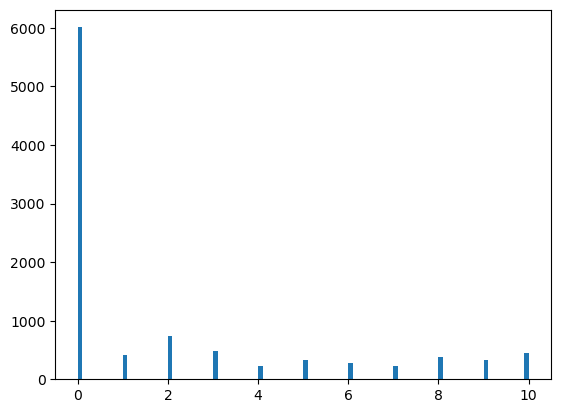

In [23]:
sim_regime = torch.tensor(
    [x for x in samples.obs.perturbation.map(gene_to_intervention_idx).values]
).long()
# intervened_variables = gt_interv[:, sim_regime].transpose(0, 1)
plt.hist(sim_regime.cpu().numpy(), bins=100)

In [24]:
samples_normalized = torch.tensor(samples.X.todense())
print(f"{samples_normalized.shape=}")

# Log x+1 transform
samples_normalized = torch.log(samples_normalized + 1)
# z-score
samples_normalized = (
    samples_normalized - samples_normalized.mean(dim=0)
) / samples_normalized.std(dim=0)

samples_normalized.shape=torch.Size([9868, 15])


(array([1.0000e+01, 0.0000e+00, 2.3000e+01, 3.9000e+01, 0.0000e+00,
        1.5400e+02, 1.4000e+02, 7.1500e+02, 5.7580e+03, 5.3437e+04,
        5.1565e+04, 5.2980e+03, 4.4300e+03, 2.2530e+03, 2.3830e+03,
        3.0500e+02, 9.0200e+02, 1.7000e+02, 5.2000e+01, 5.2000e+01,
        7.4000e+01, 2.3600e+02, 1.6900e+02, 5.0000e+00, 6.0000e+00,
        3.0000e+00, 2.0000e+00, 1.2000e+01, 2.0000e+00, 0.0000e+00,
        1.5000e+01, 0.0000e+00, 7.0000e+00, 0.0000e+00, 4.5000e+01,
        4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

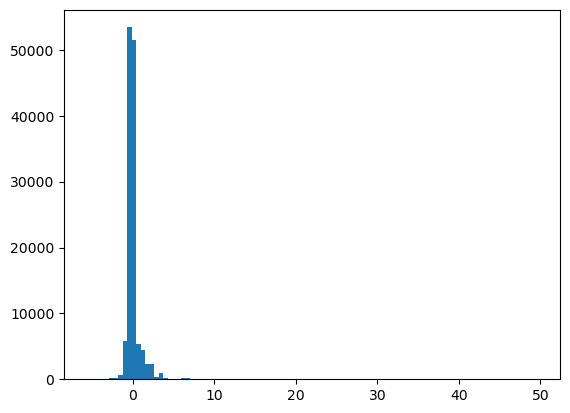

In [25]:
plt.hist(samples_normalized.flatten().cpu().numpy(), bins=100)

In [26]:
print(f"Final dataset size: {samples_normalized.shape=}")

Final dataset size: samples_normalized.shape=torch.Size([9868, 15])


In [27]:
samples_interventions = torch.tensor(
    samples.obs.perturbation.map(gene_to_intervention_idx).values
).long()
samples_interventions = samples_interventions.to(torch.int64)

train_data = torch.utils.data.TensorDataset(
    samples_normalized,
    samples_interventions,
)

In [28]:
# Stratified Sampling for train and val
train_idx, validation_idx = train_test_split(
    np.arange(len(samples_normalized)),
    test_size=0.25,
    random_state=SEED,
    shuffle=True,
    stratify=samples_interventions,
)

In [29]:
# Subset dataset for train and val
train_dataset = Subset(train_data, train_idx)
validation_dataset = Subset(train_data, validation_idx)

# Dataloader for train and val
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=4,
)
validation_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    pin_memory=True,
    num_workers=4,
)

In [30]:
lr = 1e-4
early_stopping = True
n_epochs = 25_000
n_plot_intervals = 1
lyapunov_penalty = True
perfect_interventions = True
n_genes = samples.shape[1]

GPU_DEVICE = 0
device = torch.device(f"cuda:{GPU_DEVICE}")
gt_interv = gt_interv.to(device)

for scale_l1 in [0]:
    for scale_spectral_loss in [10]:
        for scale_lyapunov in [1, 10]:
            print(f"Scale Lyapunov: {scale_lyapunov}")
            print(f"Scale spectral loss: {scale_spectral_loss}")
            model = BICYCLE(
                lr,
                gt_interv,
                n_genes,
                lyapunov_penalty=lyapunov_penalty,
                perfect_interventions=perfect_interventions,
                rank_w_cov_factor=2,
                inits=None,
                optimizer="adam",
                device=device,
                normalise=False,
                scale_l1=scale_l1,
                scale_lyapunov=scale_lyapunov,
                scale_spectral_loss=scale_spectral_loss,
                early_stopping=True,
                early_stopping_min_delta=0.02,
                early_stopping_patience=400,
                early_stopping_p_mode=True,
            )
            model.to(device)

            dlogger = DictLogger()
            loggers = [dlogger]

            from pytorch_lightning.callbacks import RichProgressBar

            assert str(device).startswith("cuda")
            trainer = pl.Trainer(
                max_epochs=n_epochs,
                accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                logger=loggers,
                log_every_n_steps=n_plot_intervals,
                enable_model_summary=True,
                enable_progress_bar=True,
                enable_checkpointing=False,
                check_val_every_n_epoch=10,
                devices=[GPU_DEVICE] if str(device).startswith("cuda") else 1,
                num_sanity_val_steps=0,
                callbacks=[RichProgressBar()],
            )

            # try:
            trainer.fit(model, train_loader)

            # Plot training curve
            fig, ax = plt.subplots(1, 2, figsize=(15, 5))
            df_plot = pd.DataFrame(
                {
                    "train_loss": trainer.logger.history["train_loss"].reset_index(
                        drop=True
                    ),
                    "val_loss": trainer.logger.history["val_loss"].reset_index(
                        drop=True
                    ),
                },
            ).reset_index(drop=True)
            ax[0].scatter(
                range(len(df_plot)), df_plot["train_loss"], label="train_loss"
            )
            ax[1].scatter(range(len(df_plot)), df_plot["val_loss"], label="val_loss")
            ax[0].grid(True)
            ax[1].grid(True)
            plt.show()

            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            sns.heatmap(
                model.beta.detach().cpu().numpy(),
                center=0,
                cmap="vlag",
                annot=True,
                fmt=".2f",
            )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Scale Lyapunov: 1
Scale spectral loss: 10


/data/m015k/miniconda3/envs/bi/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓
┃   ┃ Name ┃ Type ┃ Params ┃
┡━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩
└───┴──────┴──────┴────────┘

Trainable params: 780                                                                                              
Non-trainable params: 225                                                                                          
Total params: 1.0 K                                                                                                
Total estimated model params size (MB): 0

Output()

ValueError: Expected value argument (Tensor of shape (512, 15)) to be within the support (IndependentConstraint(Real(), 1)) of the distribution LowRankMultivariateNormal(loc: torch.Size([512, 15]), cov_factor: torch.Size([512, 15, 2]), cov_diag: torch.Size([512, 15])), but found invalid values:
tensor([[-0.1248, -0.2646,  1.0731,  ..., -0.3254, -0.0698, -0.3528],
        [-0.1248,  3.3279, -0.6171,  ..., -0.3254, -0.0698, -0.3528],
        [-0.1248, -0.2646, -0.6171,  ..., -0.3254, -0.0698, -0.3528],
        ...,
        [-0.1248, -0.2646, -0.6171,  ...,  2.4624, -0.0698, -0.3528],
        [-0.1248, -0.2646,  2.0618,  ..., -0.3254, -0.0698, -0.3528],
        [ 6.9879, -0.2646, -0.6171,  ..., -0.3254, -0.0698, -0.3528]],
       device='cuda:0')

import pandas as pd
pd.DataFrame(trainer.logger.history)